## Problem 5: Gaussian Classifiers for Digits

In [240]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys
from scipy import io
from time import time
from skimage.feature import hog

%matplotlib inline

DIGITS_TRAINING_DATA = "data/digit-dataset/train.mat"
DIGITS_TEST_DATA = "data/digit-dataset/test.mat"
COVARIANCE_CLASS_VIS = 5
NUM_CLASSES = 10
NUM_TRAINING_EXAMPLES = \
    [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
CROSSVAL_K = 10

In [2]:
def shuffle_in_unison(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [64]:
def print_now(s):
    print(s)
    sys.stdout.flush()

In [137]:
def timer(func):
    def func_wrapper(*args, **kwargs):
        start_time = time()
        print("Start processing...")
        sys.stdout.flush()
        retval = func(*args, **kwargs)
        print("Done!")
        print("Time taken: {} seconds".format(time() - start_time))
        sys.stdout.flush()
        return retval
    return func_wrapper

In [235]:
# Load data
training_data = io.loadmat(DIGITS_TRAINING_DATA)
test_data = io.loadmat(DIGITS_TEST_DATA)

image_data = \
    np.rollaxis(training_data['train_images'], 2, 0).astype(np.float)
image_labels = np.ravel(training_data['train_labels'])
image_data, image_labels = shuffle_in_unison(image_data, image_labels)
test_images = test_data['test_images'].astype(np.float)

NUM_FEATURES = 784

# Normalize images
image_data = image_data.reshape(image_data.shape[0], NUM_FEATURES)
image_data /= np.linalg.norm(image_data, axis=1).reshape((-1, 1))
train_images, validation_images = \
    image_data[:50000], image_data[50000:]
train_labels, validation_labels = \
    image_labels[:50000], image_labels[50000:]
test_images /= np.linalg.norm(test_images, axis=1).reshape((-1, 1))
test_images = \
    test_images.reshape((10000, 28, 28), order='F')\
               .reshape((10000, NUM_FEATURES))

#### Part A
The maximum likelihood estimate for the mean is:    
$$\hat\mu = E[X] = \frac{1}{n}\sum_{i=1}^n X_i$$
The maximum likelihood estimate for the covariance matrix is:
$$\Sigma = \frac{1}{n}\sum_{i=1}^n(X_i - \overline X)(X_i - \overline X)^T $$

In [256]:
priors = np.array([np.sum(train_labels==i) / \
                   float(train_labels.shape[0]) \
                   for i in range(NUM_CLASSES)])
for i, x in enumerate(priors):
    print_now("Prior probability of class {} : {}".format(i, x))

Prior probability of class 0 : 0.09888
Prior probability of class 1 : 0.11272
Prior probability of class 2 : 0.09894
Prior probability of class 3 : 0.10244
Prior probability of class 4 : 0.09848
Prior probability of class 5 : 0.08994
Prior probability of class 6 : 0.09846
Prior probability of class 7 : 0.10358
Prior probability of class 8 : 0.09718
Prior probability of class 9 : 0.09938


#### Part B
The prior distribution for each class is modelled as the number of samples in that class divided by the total number of samples.

| Digit        | Probability     |
| ------------ | --------------- |
| 0            | 0.09888         |
| 1            | 0.11272         |
| 2            | 0.09894         |
| 3            | 0.10244         |
| 4            | 0.09848         |
| 5            | 0.08994         |
| 6            | 0.09846         |
| 7            | 0.10358         |
| 8            | 0.09718         |
| 9            | 0.09938         |


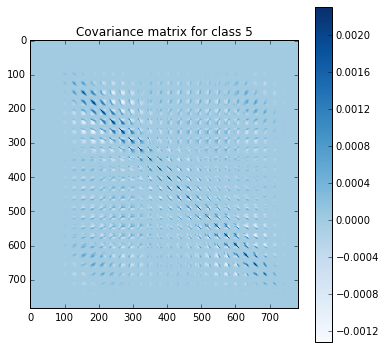

In [242]:
cov_mat = np.cov(train_images[train_labels == COVARIANCE_CLASS_VIS].T)
plt.figure(i, figsize=(6, 6))
plt.title("Covariance matrix for class {}".format(COVARIANCE_CLASS_VIS))
plt.imshow(cov_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

#### Part C
The matrix has large values on its diagonal relative to non-diagonal entries, with spaces in between "blocks" of high values. This tells us that the distinguishing features of the class (the pixels corresponding to the digit) are very different from the background.

In [243]:
def LDA(training_data, training_labels, prediction_data, gamma):
    classes_mean_MLE = \
        np.array([np.mean(training_data[training_labels == i], axis=0) \
                  for i in range(NUM_CLASSES)])
        
    cov_matrices = \
        np.array([np.cov(training_data[training_labels == i].T) \
                  for i in range(NUM_CLASSES)])
    cov_mean = np.mean(cov_matrices, axis=0) + np.eye(NUM_FEATURES) * gamma
    cov_mean_inv = np.linalg.inv(cov_mean)
    
    LDF = np.array([ \
        classes_mean_MLE[i].dot(cov_mean_inv).dot(prediction_data.T) - \
        0.5 * classes_mean_MLE[i].dot(cov_mean_inv)\
                                 .dot(classes_mean_MLE[i].T) + \
        np.log(priors[i]) for i in range(NUM_CLASSES)
    ])
    predictions = np.argmax(LDF, axis=0)
    return predictions

In [244]:
@timer
def cross_validate(training_data, training_labels, gamma_value, \
                   cross_validation_indices, CROSSVAL_K, DA_func):
    print_now("Runing cross validation for γ value of: {}".format(gamma_value))
    cross_validation_data = \
        np.array(np.split(training_data[cross_validation_indices], \
                          CROSSVAL_K))
    cross_validation_labels = \
        np.array(np.split(training_labels[cross_validation_indices], \
                          CROSSVAL_K))
    cross_validation_accuracy = 0.0
    for i in range(CROSSVAL_K):
        mask = np.ones(CROSSVAL_K, dtype=bool)
        mask[i] = 0
        test_set = np.concatenate(cross_validation_data[mask])
        test_labels = np.concatenate(cross_validation_labels[mask])
        validation_set = cross_validation_data[i]
        validation_labels = cross_validation_labels[i]
        validation_prediction = \
            DA_func(test_set, test_labels, validation_set, gamma_value)
        cross_validation_accuracy += \
            np.sum(validation_labels == validation_prediction) \
            / float(len(validation_labels))
    cross_validation_accuracy /= CROSSVAL_K
    return cross_validation_accuracy

In [245]:
@timer
def crossval(training_data, training_labels, DA_func, gamma_values):
    max_accuracy, best_gamma_value = 0.0, 0.0
    cross_validation_indices = np.arange(0, 10000)
    np.random.shuffle(cross_validation_indices)
    
    for gamma_value in gamma_values:
        cross_validation_accuracy = \
            cross_validate(training_data, training_labels, \
                gamma_value, cross_validation_indices, CROSSVAL_K, DA_func)
        print_now("Cross validation accuracy for C value {}: {}".format( \
              gamma_value, cross_validation_accuracy))
        if cross_validation_accuracy > max_accuracy:
            max_accuracy, best_gamma_value = \
                cross_validation_accuracy, gamma_value
    print_now("Best gamma value found to be: {}".format(best_gamma_value))
    return best_gamma_value

In [246]:
best_LDA_gamma_value = \
    crossval(train_images, train_labels, LDA, \
             np.array([10**i for i in range(-10, -2)]))

Start processing...
Start processing...
Runing cross validation for γ value of: 1e-10
Done!
Time taken: 4.1938698291778564 seconds
Cross validation accuracy for C value 1e-10: 0.8241999999999999
Start processing...
Runing cross validation for γ value of: 1e-09
Done!
Time taken: 4.0349438190460205 seconds
Cross validation accuracy for C value 1e-09: 0.825
Start processing...
Runing cross validation for γ value of: 1e-08
Done!
Time taken: 3.669543981552124 seconds
Cross validation accuracy for C value 1e-08: 0.8254999999999999
Start processing...
Runing cross validation for γ value of: 1e-07
Done!
Time taken: 3.9002199172973633 seconds
Cross validation accuracy for C value 1e-07: 0.827
Start processing...
Runing cross validation for γ value of: 1e-06
Done!
Time taken: 4.170966148376465 seconds
Cross validation accuracy for C value 1e-06: 0.8299
Start processing...
Runing cross validation for γ value of: 1e-05
Done!
Time taken: 4.22487998008728 seconds
Cross validation accuracy for C valu

In [247]:
@timer
def run_LDA():
    global best_gamma_value
    validation_errors = []
    for num_data_points in NUM_TRAINING_EXAMPLES:
        print_now("Training on {} data points...".format(num_data_points))
        data, labels = \
            train_images[:num_data_points], train_labels[:num_data_points]
        predictions = \
            LDA(data, labels, validation_images, best_LDA_gamma_value)
        
        error_rate = np.sum(predictions != validation_labels) \
                     / float(len(validation_labels))
        print_now("Error rate with {} training data: {}"\
                  .format(num_data_points, error_rate))
        validation_errors.append(error_rate)

    plt.title("LDA on validation data")
    plt.xlabel("Number of training examples")
    plt.ylabel("Error rate")
    plt.plot(NUM_TRAINING_EXAMPLES, validation_errors)

Start processing...
Training on 100 data points...
Error rate with 100 training data: 0.3873
Training on 200 data points...
Error rate with 200 training data: 0.3495
Training on 500 data points...
Error rate with 500 training data: 0.2842
Training on 1000 data points...
Error rate with 1000 training data: 0.2262
Training on 2000 data points...
Error rate with 2000 training data: 0.1928
Training on 5000 data points...
Error rate with 5000 training data: 0.1754
Training on 10000 data points...
Error rate with 10000 training data: 0.1637
Training on 30000 data points...
Error rate with 30000 training data: 0.1592
Training on 50000 data points...
Error rate with 50000 training data: 0.1604
Done!
Time taken: 3.681962013244629 seconds


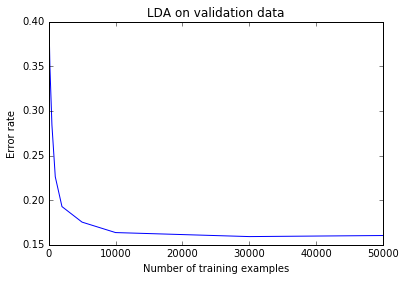

In [248]:
run_LDA()

### Part D, SubPart i)
With LDA, we see that the error rate converges after a certain amount of training data. The decision boundary is the isocontour where the Linear Discriminant Function of one class equals that of another class.

In [249]:
def QDA(training_data, training_labels, prediction_data, gamma):
    N = len(prediction_data)
    classes_mean_MLE = np.array([ \
        np.mean(training_data[training_labels == i], axis=0) \
        for i in range(NUM_CLASSES)])
        
    cov_matrices = np.array([ \
        np.cov(training_data[training_labels == i].T) + \
        np.eye(NUM_FEATURES) * gamma for i in range(NUM_CLASSES)])
    cov_matrices_inv = \
        np.array([np.linalg.inv(mat) for mat in cov_matrices])
    
    classes_mean_reshaped = np.array([ \
        np.tile(mean.reshape((NUM_FEATURES, 1)), N).T \
        for mean in classes_mean_MLE])
    
    QDF = np.array([ \
            -0.5 * (prediction_data - classes_mean_reshaped[i]) \
                    .dot(cov_matrices_inv[i]) \
                    .dot((prediction_data - classes_mean_reshaped[i]).T) \
                    .diagonal() \
            -0.5 * np.tile(np.log(np.linalg.norm(cov_matrices_inv[i])), N) \
            + np.tile(np.log(priors[i]), N) for i in range(NUM_CLASSES) \
    ])
    
    predictions = np.argmax(QDF, axis=0)
    return predictions

In [250]:
best_QDA_gamma_value = \
    crossval(train_images, train_labels, QDA, \
             np.array([10**i for i in range(-10, 0)]))

Start processing...
Start processing...
Runing cross validation for γ value of: 1e-10
Done!
Time taken: 16.141140937805176 seconds
Cross validation accuracy for C value 1e-10: 0.7854
Start processing...
Runing cross validation for γ value of: 1e-09
Done!
Time taken: 16.529905080795288 seconds
Cross validation accuracy for C value 1e-09: 0.7886000000000001
Start processing...
Runing cross validation for γ value of: 1e-08
Done!
Time taken: 15.274816989898682 seconds
Cross validation accuracy for C value 1e-08: 0.7959
Start processing...
Runing cross validation for γ value of: 1e-07
Done!
Time taken: 15.407572984695435 seconds
Cross validation accuracy for C value 1e-07: 0.8069000000000001
Start processing...
Runing cross validation for γ value of: 1e-06
Done!
Time taken: 16.228749990463257 seconds
Cross validation accuracy for C value 1e-06: 0.8369
Start processing...
Runing cross validation for γ value of: 1e-05
Done!
Time taken: 15.386128902435303 seconds
Cross validation accuracy for 

In [251]:
@timer
def run_QDA():
    global best_QDA_gamma_value
    validation_errors = []
    for num_data_points in NUM_TRAINING_EXAMPLES:
        print_now("Training on {} data points...".format(num_data_points))
        data, labels = \
            train_images[:num_data_points], train_labels[:num_data_points]
        predictions = \
            QDA(data, labels, validation_images, best_QDA_gamma_value)
        
        error_rate = np.sum(predictions != validation_labels) \
                     / float(len(validation_labels))
        print_now("Error rate with {} training data: {}" \
                  .format(num_data_points, error_rate))
        validation_errors.append(error_rate)

    plt.title("QDA on validation data")
    plt.xlabel("Number of training examples")
    plt.ylabel("Error rate")
    plt.plot(NUM_TRAINING_EXAMPLES, validation_errors)

Start processing...
Training on 100 data points...
Error rate with 100 training data: 0.3084
Training on 200 data points...
Error rate with 200 training data: 0.2142
Training on 500 data points...
Error rate with 500 training data: 0.123
Training on 1000 data points...
Error rate with 1000 training data: 0.0881
Training on 2000 data points...
Error rate with 2000 training data: 0.0683
Training on 5000 data points...
Error rate with 5000 training data: 0.0588
Training on 10000 data points...
Error rate with 10000 training data: 0.056
Training on 30000 data points...
Error rate with 30000 training data: 0.0551
Training on 50000 data points...
Error rate with 50000 training data: 0.055
Done!
Time taken: 310.90053486824036 seconds


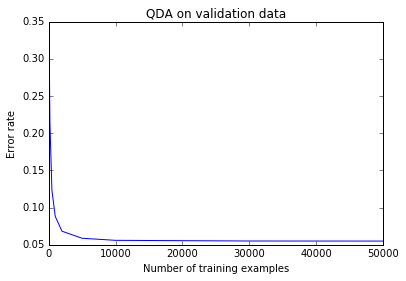

In [252]:
run_QDA()

### Part D, SubPart ii)
With QDA, we see that the error rate converges much more quickly than LDA. The decision boundary is the isocontour where the Quadratic Discriminant Function of one class equals that of another class, similar to LDA.

### Part E, SubPart iii)
The results of QDA have a much higher accuracy than LDA. This is because we use a different covariance matrix for each class, resulting in a better fit for the model used to classify each class.

### Part E, SubPart iv)
The Kaggle score I received is 0.95440. I used k-fold cross validation to find the optimum value of α.

In [ ]:
@timer
def kaggle_dataset():
    predictions = \
        QDA(image_data, image_labels, test_images, best_QDA_gamma_value)
    with open("kaggle_digits.txt", "w+") as kaggle_file:
        kaggle_file.write("Id,Category\n")
        for i in range(len(predictions)):
            kaggle_file.write(str(i+1)+","+str(predictions[i])+"\n")
        kaggle_file.close()
kaggle_dataset()